In [1]:
import sys
import os
from glob import glob
import pickle
import os
import urllib
from functools import reduce
from collections import deque
import gc

from joblib import Parallel, delayed

from tqdm import tqdm

import numpy as np

from scipy.ndimage import convolve

import pandas as pd

from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms.functional as TF

sys.path.insert(0, os.getcwd())

# import all utils
from utils import data_directory, \
                dinov3_repo_dir, \
                dinov3_vitb16_weight_raw, \
                dinov3_vith16_weight_raw, \
                dinov3_vit7B16_weight_raw, \
                dinov3_vits16p_weight_raw
                
sys.path.insert(0, os.path.join(dinov3_repo_dir))
    

In [2]:
def count_components_floodfill(row:dict, connectivity: int = 8):
    """
    Count connected True components in a 2D boolean numpy mask using flood-fill (iterative).
    Args:
        mask: 2D boolean numpy array
        connectivity: 4 or 8 (neighbour connectivity)
    Returns:
        n_components: int
        sizes: list of int (size of each component)
        labels: 2D int32 array same shape as mask where 0 = background, 1..n = component ids
    """
    mask = row['bool_mask']
    
    assert mask.ndim == 2, "mask must be 2D"
    assert connectivity in (4, 8)
    H, W = mask.shape
    visited = np.zeros((H, W), dtype=bool)
    # labels = np.zeros((H, W), dtype=np.int32)
    neighbors4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbors8 = neighbors4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    neighbors = neighbors8 if connectivity == 8 else neighbors4

    comp_id = 0
    # sizes = []

    for y in range(H):
        for x in range(W):
            if mask[y, x] and not visited[y, x]:
                comp_id += 1
                q = deque()
                q.append((y, x))
                visited[y, x] = True
                # labels[y, x] = comp_id
                # size = 0
                while q:
                    cy, cx = q.popleft()
                    # size += 1
                    for dy, dx in neighbors:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < H and 0 <= nx < W and not visited[ny, nx] and mask[ny, nx]:
                            visited[ny, nx] = True
                            # labels[ny, nx] = comp_id
                            q.append((ny, nx))
                # sizes.append(size)

    return {"name":row["name"], "index":row["index"], "bool_mask":mask, "n_comps":comp_id} #, sizes, labels


forged_folder = os.path.join(data_directory, 'train_images', 'forged')
authentic_folder = os.path.join(data_directory, 'train_images', 'authentic')
mask_folder = os.path.join(data_directory, 'train_masks')

PATCH_SIZE = 16
DEFAULT_IMAGE_SIZE = 512 # Should be multiple of PATCH_SIZE
MASK_THRESHOLD = 0

def resize_image_to_fit_patch(
    image: Image,
    image_size: int = DEFAULT_IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> Image:
    w, h = image.size
    h_hat = image_size
    w_hat = PATCH_SIZE * int(((w/h)*image_size)// PATCH_SIZE)
    resized_img = image.resize((w_hat, h_hat), \
                    resample=Image.Resampling.LANCZOS)
    return resized_img

def mask_to_resized_image(mask):
    image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    image_resized = resize_image_to_fit_patch(image)
    return image_resized

def resize_mask_to_patch_dimensions(
    mask: np.ndarray,
    mask_threshold: int = MASK_THRESHOLD,
) -> np.ndarray:
    resized_image = mask_to_resized_image(mask)
    w_hat, h_hat = resized_image.size
    patched_image = resized_image.resize(
        (w_hat // PATCH_SIZE, h_hat // PATCH_SIZE),
        resample=Image.Resampling.NEAREST)
    patched_array = np.array(patched_image)
    patched_mask = patched_array > mask_threshold
    return patched_mask

def resized_image_to_mask(image_resized, mask_threshold: int = MASK_THRESHOLD):
    image_array = np.array(image_resized)
    mask = image_array > mask_threshold
    return mask

def pixel_to_patch_coords(y_pixel, x_pixel, patch_size=PATCH_SIZE):
    y_coord = y_pixel // patch_size
    x_coord = x_pixel // patch_size
    return y_coord, x_coord

# Convert auth_mask to patch coordinates and mask the similarity map
def pixel_mask_to_patch_mask(pixel_mask, patch_size=PATCH_SIZE):
    """Convert pixel-level mask to patch-level mask"""
    H_pixels, W_pixels = pixel_mask.shape
    H_patches = H_pixels // patch_size
    W_patches = W_pixels // patch_size
    
    patch_mask = np.zeros((H_patches, W_patches), dtype=bool)
    
    for i in range(H_patches):
        for j in range(W_patches):
            # Check if any pixel in this patch is True
            patch_region = pixel_mask[i*patch_size:(i+1)*patch_size, 
                                     j*patch_size:(j+1)*patch_size]
            patch_mask[i, j] = np.any(patch_region)
    
    return patch_mask

### Extract Forged and Authentic Masks Separately

In [3]:
def get_masks(mask_file):
    ret = []
    
    mask_name = os.path.basename(mask_file).replace('.npy', '')
    
    if os.path.exists(os.path.join(forged_folder, mask_name+'.png')) is False:
        return ret

    if os.path.exists(os.path.join(authentic_folder, mask_name+'.png')) is False:
        return ret
    
    masked_image_path = os.path.join(mask_folder, mask_name+'.npy')
    masked_imgs = np.load(masked_image_path)
    masked_imgs_shape = masked_imgs.shape
    
    for i in range(masked_imgs_shape[0]):
    
        # get the i-th mask
        masked_img = masked_imgs[i]

        # Convert masked_img to boolean
        masked_img_boolean = masked_img > MASK_THRESHOLD
        
        ret.append({"name":mask_name, "index":i, "bool_mask":masked_img_boolean})
    
    return ret

mask_files = glob(os.path.join(mask_folder, '*.npy'))
all_masks = Parallel(n_jobs=-1)(delayed(get_masks)(mask_file) for mask_file in tqdm(mask_files))
all_masks = [item for sublist in all_masks for item in sublist]
pickle.dump(all_masks, open('masks.pkl', 'wb'))

100%|██████████| 2751/2751 [00:44<00:00, 62.48it/s]


In [ ]:
all_masks = pickle.load(open('masks.pkl', 'rb'))
component_counts = Parallel(n_jobs=-1)(delayed(count_components_floodfill)(row) for row in tqdm(all_masks))
pickle.dump(component_counts, open('component_counts.pkl', 'wb'))






































































































































































































































































100%|██████████| 3187/3187 [03:04<00:00, 17.26it/s]


In [4]:

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def smooth_boolean_mask(mask, kernel_size=3):
    """
    Smooths a boolean pixel mask based on a majority vote of neighboring pixels.
    Kernel/accumulators use int32 to avoid overflow for large kernels.
    """
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("kernel_size must be an odd integer >= 3")

    # Use int32 to avoid overflow when summing large neighborhoods
    int_mask = mask.astype(np.int32)

    kernel = np.ones((kernel_size, kernel_size), dtype=np.int32)

    neighbor_sum = convolve(int_mask, kernel, mode='constant', cval=0)

    # majority threshold excluding center? here we keep original behavior:
    majority_threshold = (kernel_size * kernel_size) / 2

    new_mask = neighbor_sum > majority_threshold

    return new_mask.astype(bool)

def smooth_boolean_mask2(mask, kernel_size=3):
    """
    Smooth boolean mask: a pixel becomes False only if a strict majority of its neighbors
    (excluding itself) are False; otherwise it keeps its original value.

    Uses int32 accumulator to prevent overflow when kernel_size grows.
    """
    if kernel_size % 2 == 0 or kernel_size < 3:
        raise ValueError("kernel_size must be an odd integer >= 3")

    # Use int32 to avoid overflow
    int_mask = mask.astype(np.int32)

    kernel = np.ones((kernel_size, kernel_size), dtype=np.int32)

    # Convolve to get sum including center
    neighbor_sum_incl = convolve(int_mask, kernel, mode='constant', cval=0)

    # Sum of neighbors only (exclude the center pixel)
    neighbors_sum = neighbor_sum_incl - int_mask

    # Number of neighbors (excluding center)
    n_neighbors = kernel_size * kernel_size - 1

    # Count of False neighbors
    false_neighbors = n_neighbors - neighbors_sum

    # Majority threshold: strict majority of neighbors being False
    majority_threshold = n_neighbors // 2

    # New mask: keep original value unless majority of neighbors are False -> set False
    new_mask = mask.copy().astype(bool)
    majority_false = false_neighbors > majority_threshold
    new_mask[majority_false] = False

    return new_mask

def process_mask(row):
    
    mask_name = row["name"]
    
    # print(mask_name, row["index"])
    
    forged_image_path = os.path.join(forged_folder, mask_name+'.png')
    forged_img = Image.open(forged_image_path).convert('RGB')

    auth_image_path = os.path.join(authentic_folder, mask_name+'.png')
    auth_img = Image.open(auth_image_path).convert('RGB')
    
    # Subtract auth_img from forged_img and convert to boolean mask
    forged_array = np.sum(np.array(forged_img), axis=2)
    forged_array = (forged_array - np.min(forged_array))/(np.max(forged_array) - np.min(forged_array))
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(forged_array, cmap='gray')
    # plt.title(f'Forged')
    # plt.axis('off')
    
    auth_array = np.sum(np.array(auth_img), axis=2)
    auth_array = (auth_array - np.min(auth_array))/(np.max(auth_array) - np.min(auth_array))
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(auth_array, cmap='gray')
    # plt.title(f'Auth')
    # plt.axis('off')

    # Calculate absolute difference
    diff_array = np.abs(forged_array.astype(np.float32) - auth_array.astype(np.float32))

    # Convert to grayscale by taking mean across channels
    # diff_gray = np.mean(diff_array, axis=2)

    # Create boolean mask (threshold can be adjusted)
    DIFF_THRESHOLD = 0  # Adjust this value as needed
    diff_boolean_mask = diff_array > DIFF_THRESHOLD
    diff_boolean_mask = diff_boolean_mask.astype(bool)
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(diff_boolean_mask, cmap='gray')
    # plt.title(f'Diff')
    # plt.axis('off')
    
    if not np.any(diff_boolean_mask):
        return None
    
    # Smooth the diff boolean mask
    kernel_size = 3
    last_diff_boolean_mask = diff_boolean_mask.copy()
    it = 0
    while 1:
        while 1:
            it += 1
            prev_mask = diff_boolean_mask.copy()
            diff_boolean_mask = smooth_boolean_mask2(diff_boolean_mask, kernel_size=kernel_size)
            if np.array_equal(prev_mask, diff_boolean_mask):
                del prev_mask
                gc.collect()
                break
        
        n_comps = count_components_floodfill({"name":mask_name, \
                                    "index":-1, \
                                    "bool_mask":diff_boolean_mask})["n_comps"]
        kernel_size += 2
        if not np.any(diff_boolean_mask):
            break
        if np.array_equal(last_diff_boolean_mask, diff_boolean_mask):
            continue
        last_diff_boolean_mask = diff_boolean_mask
        if n_comps <= row["n_comps"]-1:
            break
        
    diff_boolean_mask = last_diff_boolean_mask
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(diff_boolean_mask, cmap='gray')
    # plt.title(f'Diff')
    # plt.axis('off')
    
    
    # diff_boolean_mask = resize_mask_to_patch_dimensions(diff_boolean_mask)
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(diff_boolean_mask, cmap='gray')
    # plt.title(f'Diff')
    # plt.axis('off')
    
    masked_img_boolean = row["bool_mask"]
    # masked_img_boolean = resize_mask_to_patch_dimensions(masked_img_boolean)
    
    
    # find intersections between diff_boolean_mask and masked_img_boolean
    forged_mask = np.logical_and(diff_boolean_mask, masked_img_boolean)
    if not np.any(diff_boolean_mask):
        return None
    
    # Smooth the boolean mask
    kernel_size = 3
    last_forged_mask = forged_mask.copy()
    it = 0
    while 1:
        while 1:
            it += 1
            prev_mask = forged_mask.copy()
            forged_mask = smooth_boolean_mask2(forged_mask, kernel_size=kernel_size)
            if np.array_equal(prev_mask, forged_mask):
                del prev_mask
                gc.collect()
                break
        n_comps = count_components_floodfill({"name":mask_name, \
                                    "index":-1, \
                                    "bool_mask":forged_mask})["n_comps"]
        kernel_size += 2
        if not np.any(forged_mask):
            break
        if np.array_equal(last_forged_mask, forged_mask):
            continue
        last_forged_mask = forged_mask
        if n_comps <= row["n_comps"]-1:
            break
    forged_mask = last_forged_mask
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(resize_mask_to_patch_dimensions(forged_mask), cmap='gray')
    # plt.title(f'Forged')
    # plt.axis('off')
    
    # get auth mask
    auth_mask = masked_img_boolean & ~forged_mask
    if not np.any(auth_mask):
        return None
    
    # Smooth the boolean mask
    kernel_size = 3
    last_auth_mask = auth_mask.copy()
    it = 0
    while 1:
        while 1:
            it += 1
            prev_mask = auth_mask.copy()
            auth_mask = smooth_boolean_mask(auth_mask, kernel_size=kernel_size)
            if np.array_equal(prev_mask, auth_mask):
                del prev_mask
                gc.collect()
                break
        n_comps = count_components_floodfill({"name":mask_name, \
                                    "index":-1, \
                                    "bool_mask":auth_mask})["n_comps"]
        kernel_size += 2
        if not np.any(auth_mask):
            break
        if np.array_equal(last_auth_mask, auth_mask):
            continue
        last_auth_mask = auth_mask
        if n_comps <= 1:
            break
    auth_mask = last_auth_mask
    
    # # visualize the masks
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.imshow(resize_mask_to_patch_dimensions(auth_mask), cmap='gray')
    # plt.title(f'Auth')
    # plt.axis('off')


    me = {"mask_name": mask_name, \
                "index": row["index"], \
                "auth_mask": resize_mask_to_patch_dimensions(auth_mask), \
                "forged_mask": resize_mask_to_patch_dimensions(forged_mask),}
    return me
    # pickle.dump(me, open(os.path.join('mask_entities', f'{mask_name}.pkl'), 'wb'))

component_counts = pickle.load(open('component_counts.pkl', 'rb'))

# chunk_size = 24  # adjust as needed
# total = len(component_counts)
# n_chunks = (total + chunk_size - 1) // chunk_size
# for chunk_idx, start in enumerate(range(0, total, chunk_size), 1):
#     end = min(start + chunk_size, total)
#     chunk = component_counts[start:end]
#     print(f"Processing chunk {chunk_idx}/{n_chunks} (items {start}:{end})")
#     # process this chunk in parallel
#     Parallel(n_jobs=-1)(delayed(process_mask)(row) for row in tqdm(chunk))
#     # masked_entities = [item for sublist in masked_entities for item in sublist]
#     # pickle.dump(masked_entities, open(os.path.join('mask_entities', f'mask_components{chunk_idx}.pkl'), 'wb'))
    


# for row in tqdm(component_counts):
#     process_mask(row)

masked_entities = Parallel(n_jobs=-1)(delayed(process_mask)(row) for row in tqdm(component_counts[:36]))
# # masked_entities = [process_mask(component_counts[0])] # 19684  13511
# masked_entities = [process_mask(x) for x in component_counts if x["name"]=="19684"] # 19684  13511
masked_entities = [item for item in masked_entities if item is not None]
pickle.dump(masked_entities, open('mask_components.pkl', 'wb'))

100%|██████████| 36/36 [00:06<00:00,  5.46it/s]


In [7]:
masked_entities = pickle.load(open('mask_components.pkl', 'rb'))
masked_entities[0]

{'mask_name': '10',
 'index': 0,
 'auth_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(32, 40)),
 'forged_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(32, 40))}

{'name': '10', 'index': 0, 'bool_mask': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(32, 40)), 'n_comps': 1}
(32, 40)


(np.float64(-0.5), np.float64(39.5), np.float64(31.5), np.float64(-0.5))

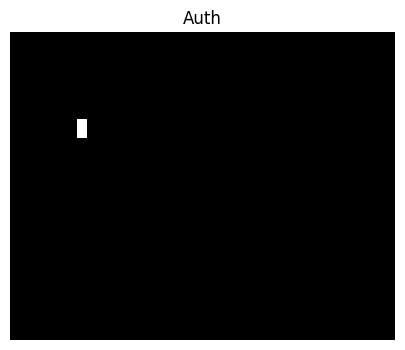

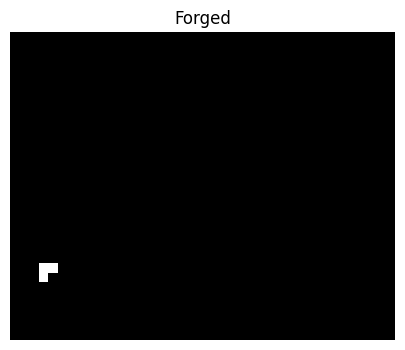

In [8]:
print(count_components_floodfill({"name":masked_entities[0]["mask_name"], "index":masked_entities[0]["index"], "bool_mask":masked_entities[0]["auth_mask"]}))
print(masked_entities[0]["auth_mask"].shape)

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(masked_entities[0]["auth_mask"], cmap='gray')
plt.title(f'Auth')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(masked_entities[0]["forged_mask"], cmap='gray')
plt.title(f'Forged')
plt.axis('off')

In [9]:
len(masked_entities)

36

In [10]:
def auth_and_forged_sim_mat(auth_mask, forged_mask):
    """
    Calculate similarity matrix between authentic and forged patches using matrix multiplication
    
    Args:
        auth_mask: Boolean array of shape [H1, W1]
        forged_mask: Boolean array of shape [H2, W2]
        
    Returns:
        similarity_matrix: Tensor of shape [H1, W1, H2, W2]
    """
    # Convert boolean masks to float tensors
    if not isinstance(auth_mask, torch.Tensor):
        auth_mask = torch.from_numpy(auth_mask.astype(np.float32))
    if not isinstance(forged_mask, torch.Tensor):
        forged_mask = torch.from_numpy(forged_mask.astype(np.float32))
    
    # Get dimensions
    H1, W1 = auth_mask.shape
    H2, W2 = forged_mask.shape
    
    # Reshape to [N1, 1] and [N2, 1] where N1 = H1*W1 and N2 = H2*W2
    auth_features = auth_mask.reshape(-1, 1)
    forged_features = forged_mask.reshape(-1, 1)
    
    # Normalize features
    auth_features = F.normalize(auth_features, p=2, dim=1)
    forged_features = F.normalize(forged_features, p=2, dim=1)
    
    # Calculate similarity matrix: [N1, 1] × [1, N2] = [N1, N2]
    similarity_matrix = torch.matmul(auth_features, forged_features.T)
    
    # Reshape to [H1, W1, H2, W2] for easier interpretation
    similarity_matrix = similarity_matrix.reshape(H1, W1, H2, W2)
    
    return similarity_matrix


# Example usage:
def visualize_similarity_matrix(similarity_matrix, title="Patch Similarity Matrix"):
    """Visualize the similarity matrix with a heatmap"""
    H1, W1, H2, W2 = similarity_matrix.shape
    
    # Reshape to 2D for visualization
    sim_mat_2d = similarity_matrix.reshape(H1*W1, H2*W2)
    
    plt.figure(figsize=(100, 80))
    plt.imshow(sim_mat_2d.cpu().numpy(), cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar(label='Cosine Similarity')
    plt.title(title)
    plt.xlabel('Forged Patches')
    plt.ylabel('Authentic Patches')
    plt.tight_layout()
    plt.show()

# Use with your data:
    
# Calculate similarity matrix
similarity_matrix = auth_and_forged_sim_mat(
    masked_entities[0]["auth_mask"],
    masked_entities[0]["forged_mask"]
)

# Visualize
visualize_similarity_matrix(
    similarity_matrix,
    f"Patch Similarity Matrix for {masked_entities[0]['mask_name']}"
)

# Optional: Find highest similarity matches
max_similarities, max_indices = torch.max(similarity_matrix.reshape(-1, similarity_matrix.shape[-1]), dim=1)

print(f"Top 5 highest similarities:")
top_k = 5
top_similarities, top_indices = torch.topk(max_similarities, top_k)

for i, (sim, idx) in enumerate(zip(top_similarities, top_indices)):
    auth_idx = idx // similarity_matrix.shape[-1]
    forged_idx = idx % similarity_matrix.shape[-1]
    print(f"{i+1}. Similarity: {sim:.3f}, Auth patch: {auth_idx}, Forged patch: {forged_idx}")

Top 5 highest similarities:
1. Similarity: 1.000, Auth patch: 326, Forged patch: 8
2. Similarity: 1.000, Auth patch: 294, Forged patch: 9
3. Similarity: 1.000, Auth patch: 326, Forged patch: 9
4. Similarity: 1.000, Auth patch: 294, Forged patch: 8
5. Similarity: 0.000, Auth patch: 0, Forged patch: 3


In [5]:
class GramLoss(nn.Module):
    """Implementation of the gram loss"""

    def __init__(
        self,
        apply_norm=True,
        img_level=True,
        remove_neg=True,
        remove_only_teacher_neg=False,
    ):
        super().__init__()

        # Loss
        self.mse_loss = torch.nn.MSELoss()

        # Parameters
        self.apply_norm = apply_norm
        self.remove_neg = remove_neg
        self.remove_only_teacher_neg = remove_only_teacher_neg

        if self.remove_neg or self.remove_only_teacher_neg:
            assert self.remove_neg != self.remove_only_teacher_neg
            
    
    def auth_and_forged_sim_mat(self, auth_mask, forged_mask):
        """
        Calculate similarity matrix between authentic and forged patches using matrix multiplication
            
        Returns:
            similarity_matrix: Tensor of shape [H1, W1, H2, W2]
        """
        
        # Get dimensions
        H1, W1 = auth_mask.shape
        H2, W2 = forged_mask.shape
        
        # Reshape to [N1, 1] and [N2, 1] where N1 = H1*W1 and N2 = H2*W2
        auth_features = auth_mask.reshape(1, H1, W1, 1)
        forged_features = forged_mask.reshape(1, H2, W2, 1)
        
        # Patch correlation
        if self.apply_norm:
            auth_features = F.normalize(auth_features, dim=-1)
            forged_features = F.normalize(forged_features, dim=-1)
            
        similarity_matrix = torch.matmul(auth_features, forged_features.transpose(-1, -2))
        
        # # Normalize features
        # auth_features = F.normalize(auth_features, p=2, dim=1)
        # forged_features = F.normalize(forged_features, p=2, dim=1)
        
        # # Calculate similarity matrix: [N1, 1] × [1, N2] = [N1, N2]
        # similarity_matrix = torch.matmul(auth_features, forged_features.T)
        
        return similarity_matrix


    def forward(self, output_feats, auth_mask, forged_mask, img_level=True):
        """Compute the MSE loss between the gram matrix of the input and target features.
        Returns:
            loss: scalar
        """

        # Dimensions of the tensor should be (B, N, dim)
        if img_level:
            assert len(output_feats.shape) == 3
            
        target_sim = self.auth_and_forged_sim_mat(auth_mask, auth_mask)
        
        # print(target_sim.shape)

        # Float casting
        output_feats = output_feats.float()

        # Patch correlation
        if self.apply_norm:
            output_feats = F.normalize(output_feats, dim=-1)

        if not img_level and len(output_feats.shape) == 3:
            # Flatten (B, N, D) into  (B*N, D)
            output_feats = output_feats.flatten(0, 1)
            
        # print(output_feats.shape)

        # Compute similarities
        student_sim = torch.matmul(output_feats, output_feats.transpose(-1, -2))
        
        # print(student_sim.shape)

        if self.remove_neg:
            target_sim[target_sim < 0] = 0.0
            student_sim[student_sim < 0] = 0.0

        elif self.remove_only_teacher_neg:
            # Remove only the negative sim values of the teacher
            target_sim[target_sim < 0] = 0.0
            student_sim[(student_sim < 0) & (target_sim < 0)] = 0.0

        return self.mse_loss(student_sim, target_sim)

In [4]:

# Available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-H
MODEL_NAME = MODEL_DINOV3_VITB

model = torch.hub.load(
    repo_or_dir=dinov3_repo_dir,
    model=MODEL_NAME,
    source="local",
    weights=dinov3_vitb16_weight_raw,
)
model.cuda()

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

In [13]:
masked_entities = pickle.load(open('mask_components.pkl', 'rb'))

for row in tqdm(masked_entities):
    
    print(row["mask_name"], row["index"])
    
    forged_image_path = os.path.join(forged_folder, row["mask_name"]+'.png')
    forged_image = Image.open(forged_image_path).convert('RGB')
    
    with torch.inference_mode(): 
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            
            # Forged Image
            forged_image_resized = resize_image_to_fit_patch(forged_image)
            forged_image_tensor = TF.to_tensor(forged_image_resized)
            forged_image_normalized_tensor = TF.normalize(forged_image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            forged_image_tensorized = forged_image_normalized_tensor.unsqueeze(0).cuda()
            
            forged_feats = model.get_intermediate_layers(forged_image_tensorized, \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            forged_patch_features = forged_feats[-1].squeeze().detach().cpu()
            
            # Convert from [D, H, W] to [H, W, D]
            forged_patch_features_2d = forged_patch_features.permute(1, 2, 0)
            print(forged_patch_features_2d.shape)

            break
            
            # pickle.dump({
            #         "mask_name": row["mask_name"],
            #         "index": row["index"],
            #         "auth_patch_features_2d": auth_patch_features_2d,   
            #         "forged_patch_features_2d": forged_patch_features_2d,
            #     }, open(os.path.join(data_directory, 'embeddings', row["mask_name"] + '.pkl'), 'wb'))

  0%|          | 0/36 [00:00<?, ?it/s]

10 0


  0%|          | 0/36 [00:00<?, ?it/s]

torch.Size([32, 40, 768])


In [8]:
model.train()
device = next(model.parameters()).device
gram_loss_fn = GramLoss(apply_norm=True, img_level=True, remove_neg=True)  

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=0.05
)

for epoch in range(10):
    total_loss = 0
    # progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    # Zero gradients
    optimizer.zero_grad()
    
    for row in tqdm(masked_entities[:-1]):
        
        print(row["mask_name"], row["index"])
    
        forged_image_path = os.path.join(forged_folder, row["mask_name"]+'.png')
        forged_image = Image.open(forged_image_path).convert('RGB')
        forged_image_resized = resize_image_to_fit_patch(forged_image)
        # print(forged_image_resized.size)
        forged_image_tensor = TF.to_tensor(forged_image_resized)
        forged_image_normalized_tensor = TF.normalize(forged_image_tensor, \
                                        mean=IMAGENET_MEAN, \
                                        std=IMAGENET_STD)
        forged_image_tensorized = forged_image_normalized_tensor.unsqueeze(0).cuda()
        
        
        
        # Get model features
        with torch.cuda.amp.autocast():
            features = model.get_intermediate_layers(
                forged_image_tensorized,
                n=range(n_layers),
                reshape=True,
                norm=True
            )
            patch_features = features[-1].squeeze()  # Use last layer features
            patch_features = patch_features.permute(1, 2, 0).unsqueeze(0)  # [H, W, D]
            # print(patch_features.shape)
        
        
        # Convert boolean masks to float tensors
        if not isinstance(row["auth_mask"], torch.Tensor):
            auth_mask = torch.from_numpy(row["auth_mask"].astype(np.float32))
        if not isinstance(row["forged_mask"], torch.Tensor):
            forged_mask = torch.from_numpy(row["forged_mask"].astype(np.float32))
            
        auth_mask = auth_mask.cuda()
        forged_mask = forged_mask.cuda()
        
        # Calculate loss
        loss = gram_loss_fn(
            patch_features,
            auth_mask,
            forged_mask,
            img_level=False
        )
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update progress
        total_loss += loss.item()

  0%|          | 0/35 [00:00<?, ?it/s]C:\Users\vishn\AppData\Local\Temp\ipykernel_21044\3510389386.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


10 0


  6%|▌         | 2/35 [00:01<00:15,  2.14it/s]

10015 0
10017 0


 11%|█▏        | 4/35 [00:04<00:35,  1.14s/it]

10030 0
10070 0


 17%|█▋        | 6/35 [00:04<00:15,  1.82it/s]

10070 1
1008 0


 20%|██        | 7/35 [00:05<00:14,  1.89it/s]

10138 0


 26%|██▌       | 9/35 [00:05<00:09,  2.70it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:06<00:05,  4.23it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:06<00:04,  4.66it/s]

10152 0


 40%|████      | 14/35 [00:06<00:04,  4.25it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:07<00:03,  5.56it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:07<00:02,  6.76it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:07<00:02,  7.32it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:07<00:01,  7.23it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:07<00:01,  8.27it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:08<00:01,  8.53it/s]

10408 0


 77%|███████▋  | 27/35 [00:08<00:01,  5.88it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:08<00:00,  6.81it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:09<00:01,  3.86it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:09<00:00,  5.01it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:10<00:00,  3.42it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  9.00it/s]

10015 0


  6%|▌         | 2/35 [00:00<00:04,  6.76it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.64it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:04,  7.69it/s]

10070 0


 17%|█▋        | 6/35 [00:00<00:03,  8.59it/s]

10070 1
1008 0


 20%|██        | 7/35 [00:01<00:06,  4.23it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.31it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:01<00:04,  5.66it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:03,  5.83it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.69it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:02<00:03,  5.90it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.63it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.20it/s]

10277 0
10290 0


 66%|██████▌   | 23/35 [00:03<00:01,  7.92it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:03<00:01,  8.29it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.63it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  6.14it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.74it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.88it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.08it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.69it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  9.93it/s]

10015 0


 11%|█▏        | 4/35 [00:00<00:03,  8.11it/s]

10017 0
10030 0


 14%|█▍        | 5/35 [00:00<00:03,  8.46it/s]

10070 0
10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.92it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.28it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.19it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:01<00:04,  5.54it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.66it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.57it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.69it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.71it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.04it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:03<00:01,  7.28it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:03<00:01,  8.37it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.48it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  5.89it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.66it/s]

10435 1
10448 0


 86%|████████▌ | 30/35 [00:05<00:01,  3.07it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  4.87it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


10602 0


  3%|▎         | 1/35 [00:00<00:03,  9.78it/s]

10 0
10015 0


  6%|▌         | 2/35 [00:00<00:04,  7.17it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.36it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:04,  7.50it/s]

10070 0


 14%|█▍        | 5/35 [00:00<00:03,  7.85it/s]

10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.30it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.13it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.19it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:01<00:04,  5.66it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.75it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.64it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.52it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.82it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.48it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:03<00:01,  7.31it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:03<00:01,  8.26it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.48it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  5.86it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.62it/s]

10435 1
10448 0


 86%|████████▌ | 30/35 [00:05<00:01,  3.07it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  4.86it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  8.69it/s]

10015 0


  6%|▌         | 2/35 [00:00<00:05,  6.56it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.62it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:04,  7.36it/s]

10070 0


 14%|█▍        | 5/35 [00:00<00:03,  7.83it/s]

10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.36it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.15it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.11it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:02<00:04,  5.55it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.71it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.67it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.81it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.92it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.21it/s]

10277 0
10290 0


 66%|██████▌   | 23/35 [00:03<00:01,  7.90it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:04<00:01,  8.15it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.33it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  5.99it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.60it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.87it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.08it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.63it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  9.55it/s]

10015 0


  9%|▊         | 3/35 [00:00<00:04,  7.62it/s]

10017 0
10030 0


 14%|█▍        | 5/35 [00:00<00:03,  8.14it/s]

10070 0
10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.48it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.25it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.12it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:02<00:04,  5.55it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.72it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.60it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.76it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.80it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.29it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:03<00:01,  7.42it/s]

10296 0
10348 0
10348 1


 71%|███████▏  | 25/35 [00:04<00:01,  8.16it/s]

10398 0
10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  6.02it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.77it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.89it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.15it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.63it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  8.60it/s]

10015 0


  6%|▌         | 2/35 [00:00<00:04,  6.76it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.65it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:03,  7.79it/s]

10070 0


 14%|█▍        | 5/35 [00:00<00:03,  8.27it/s]

10070 1


 17%|█▋        | 6/35 [00:00<00:04,  7.21it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.04it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.22it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:02<00:04,  5.58it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.69it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.60it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.94it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.90it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:01,  7.50it/s]

10277 0
10290 0


 66%|██████▌   | 23/35 [00:03<00:01,  7.82it/s]

10296 0
10348 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.51it/s]

10348 1
10398 0
10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  6.15it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.67it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.96it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.14it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.63it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  9.39it/s]

10015 0


  9%|▊         | 3/35 [00:00<00:04,  7.63it/s]

10017 0
10030 0


 14%|█▍        | 5/35 [00:00<00:03,  8.33it/s]

10070 0
10070 1
1008 0


 20%|██        | 7/35 [00:01<00:05,  4.91it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:05,  4.67it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:01<00:04,  5.76it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.64it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.55it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:02<00:03,  5.69it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.60it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.37it/s]

10277 0
10290 0


 66%|██████▌   | 23/35 [00:03<00:01,  7.95it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:03<00:01,  8.22it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.25it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  5.83it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.63it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.86it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.18it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.67it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:04,  7.34it/s]

10015 0


  6%|▌         | 2/35 [00:00<00:05,  6.36it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.33it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:04,  7.39it/s]

10070 0


 14%|█▍        | 5/35 [00:00<00:03,  7.81it/s]

10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.19it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.17it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.28it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:02<00:04,  5.57it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.69it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.50it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.84it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.85it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.31it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:03<00:01,  7.48it/s]

10296 0
10348 0
10348 1


 71%|███████▏  | 25/35 [00:04<00:01,  8.60it/s]

10398 0
10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  6.12it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.75it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.92it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:05<00:00,  5.20it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.65it/s]


10602 0


  0%|          | 0/35 [00:00<?, ?it/s]

10 0


  3%|▎         | 1/35 [00:00<00:03,  9.82it/s]

10015 0


  6%|▌         | 2/35 [00:00<00:04,  6.88it/s]

10017 0


  9%|▊         | 3/35 [00:00<00:04,  7.75it/s]

10030 0


 11%|█▏        | 4/35 [00:00<00:04,  7.72it/s]

10070 0


 14%|█▍        | 5/35 [00:00<00:03,  7.91it/s]

10070 1


 17%|█▋        | 6/35 [00:00<00:03,  8.13it/s]

1008 0


 20%|██        | 7/35 [00:01<00:06,  4.11it/s]

10138 0


 26%|██▌       | 9/35 [00:01<00:06,  4.21it/s]

10139 0
10139 1


 31%|███▏      | 11/35 [00:02<00:04,  5.47it/s]

10139 2
10147 0


 34%|███▍      | 12/35 [00:02<00:04,  5.64it/s]

10152 0


 40%|████      | 14/35 [00:02<00:04,  4.64it/s]

10176 0
10176 1


 46%|████▌     | 16/35 [00:03<00:03,  5.74it/s]

10180 0
10208 0


 51%|█████▏    | 18/35 [00:03<00:02,  6.70it/s]

10266 0
10266 1


 57%|█████▋    | 20/35 [00:03<00:02,  7.21it/s]

10277 0
10290 0


 63%|██████▎   | 22/35 [00:03<00:01,  7.26it/s]

10296 0
10348 0


 69%|██████▊   | 24/35 [00:04<00:01,  7.75it/s]

10348 1
10398 0


 71%|███████▏  | 25/35 [00:04<00:01,  8.04it/s]

10408 0


 77%|███████▋  | 27/35 [00:04<00:01,  5.59it/s]

1041 0
10435 0


 83%|████████▎ | 29/35 [00:04<00:00,  6.50it/s]

10435 1
10448 0


 89%|████████▊ | 31/35 [00:05<00:01,  3.83it/s]

10457 0
10458 0


 94%|█████████▍| 33/35 [00:06<00:00,  5.10it/s]

10476 0
10570 0


100%|██████████| 35/35 [00:06<00:00,  5.58it/s]

10602 0


In [9]:
# Save model checkpoint with training info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_name': MODEL_NAME,
    'num_layers': n_layers
}

# Create checkpoints directory if it doesn't exist 
os.makedirs('checkpoints', exist_ok=True)

# Save checkpoint
checkpoint_path = os.path.join('weights', f'dinov3_finetuned.pth')
torch.save(checkpoint, checkpoint_path)

print(f"Model checkpoint saved to {checkpoint_path}")

Model checkpoint saved to weights\dinov3_finetuned.pth


In [10]:
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    
    # Initialize model with same architecture
    model = torch.hub.load(
        repo_or_dir=dinov3_repo_dir,
        model=checkpoint['model_name'],
        source="local",
        weights=dinov3_vitb16_weight_raw,
    )
    
    # Load saved weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Optionally load optimizer state if continuing training
    optimizer = torch.optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

# Example usage:
model, optimizer = load_checkpoint('weights/dinov3_finetuned.pth')

In [13]:
model.to('cuda')

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [25]:

masked_entities_with_features = []

for row in tqdm(masked_entities[0:1]):
    
    with torch.inference_mode(): 
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            
            # processing Auth mask
            auth_mask = row["auth_mask"]
            auth_mask_pil = Image.fromarray((auth_mask * 255).astype(np.uint8), mode='L')
            auth_image = auth_mask_pil.convert('RGB')
            auth_image_resized = resize_image_to_fit_patch(auth_image)
            auth_image_tensor = TF.to_tensor(auth_image_resized)
            auth_image_normalized_tensor = TF.normalize(auth_image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            auth_image_tensorized = auth_image_normalized_tensor.unsqueeze(0).cuda()
            
            auth_feats = model.get_intermediate_layers(auth_image_tensorized, \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            auth_patch_features = auth_feats[-1].squeeze().detach().cpu()
            
            # Convert from [D, H, W] to [H, W, D]
            auth_patch_features_2d = auth_patch_features.permute(1, 2, 0)
            
            # processing Forged mask
            forged_mask = row["forged_mask"]
            forged_mask_pil = Image.fromarray((forged_mask * 255).astype(np.uint8), mode='L')
            forged_image = forged_mask_pil.convert('RGB')
            forged_image_resized = resize_image_to_fit_patch(forged_image)
            forged_image_tensor = TF.to_tensor(forged_image_resized)
            forged_image_normalized_tensor = TF.normalize(forged_image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            forged_image_tensorized = forged_image_normalized_tensor.unsqueeze(0).cuda()
            
            forged_feats = model.get_intermediate_layers(forged_image_tensorized, \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            forged_patch_features = forged_feats[-1].squeeze().detach().cpu()
            
            # Convert from [D, H, W] to [H, W, D]
            forged_patch_features_2d = forged_patch_features.permute(1, 2, 0)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\vishn\AppData\Local\Temp\ipykernel_21044\4119370630.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  auth_mask_pil = Image.fromarray((auth_mask * 255).astype(np.uint8), mode='L')
C:\Users\vishn\AppData\Local\Temp\ipykernel_21044\4119370630.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  forged_mask_pil = Image.fromarray((forged_mask * 255).astype(np.uint8), mode='L')
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


In [26]:
row

{'mask_name': '10',
 'index': 0,
 'auth_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(32, 40)),
 'forged_mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]], shape=(32, 40))}

(np.float64(-0.5), np.float64(39.5), np.float64(31.5), np.float64(-0.5))

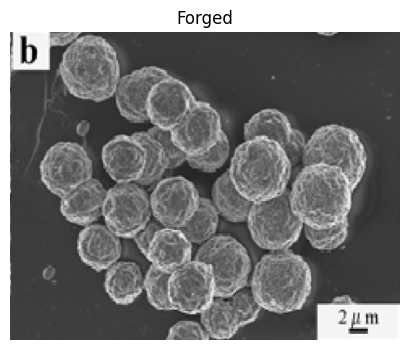

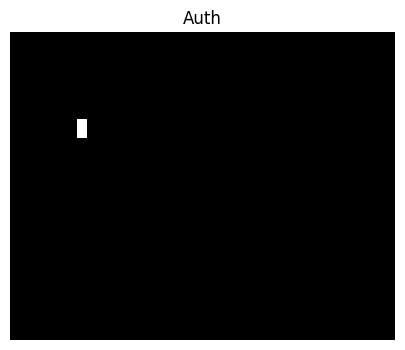

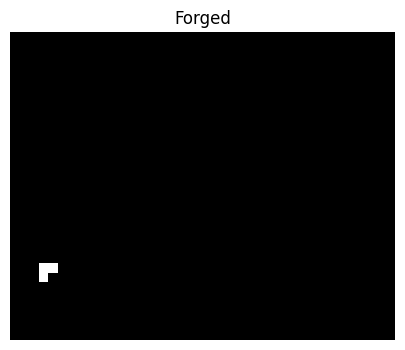

In [27]:
forged_image_path = os.path.join(forged_folder, row["mask_name"]+'.png')
forged_image = Image.open(forged_image_path).convert('RGB')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(forged_image)
plt.title(f'Forged')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(auth_mask, cmap='gray')
plt.title(f'Auth')
plt.axis('off')

# visualize the masks
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(forged_mask, cmap='gray')
plt.title(f'Forged')
plt.axis('off')

In [28]:
flag = False
for i, row in enumerate(np.mean(np.array(auth_image_resized), axis=2)):
    for j,val in enumerate(row):
        if val == 1:
            x_coord, y_coord = i//16, j//16
            flag = True
            break
    if flag:
        break

Reference patch coordinates: (6, 7)
Cosine similarity map shape: torch.Size([32, 40])
Max similarity: 0.9371
Min similarity: 0.1142
Similarity threshold: 0.87
Number of patches above threshold: 63


C:\Users\vishn\AppData\Local\Temp\ipykernel_21044\2551757493.py:54: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o',


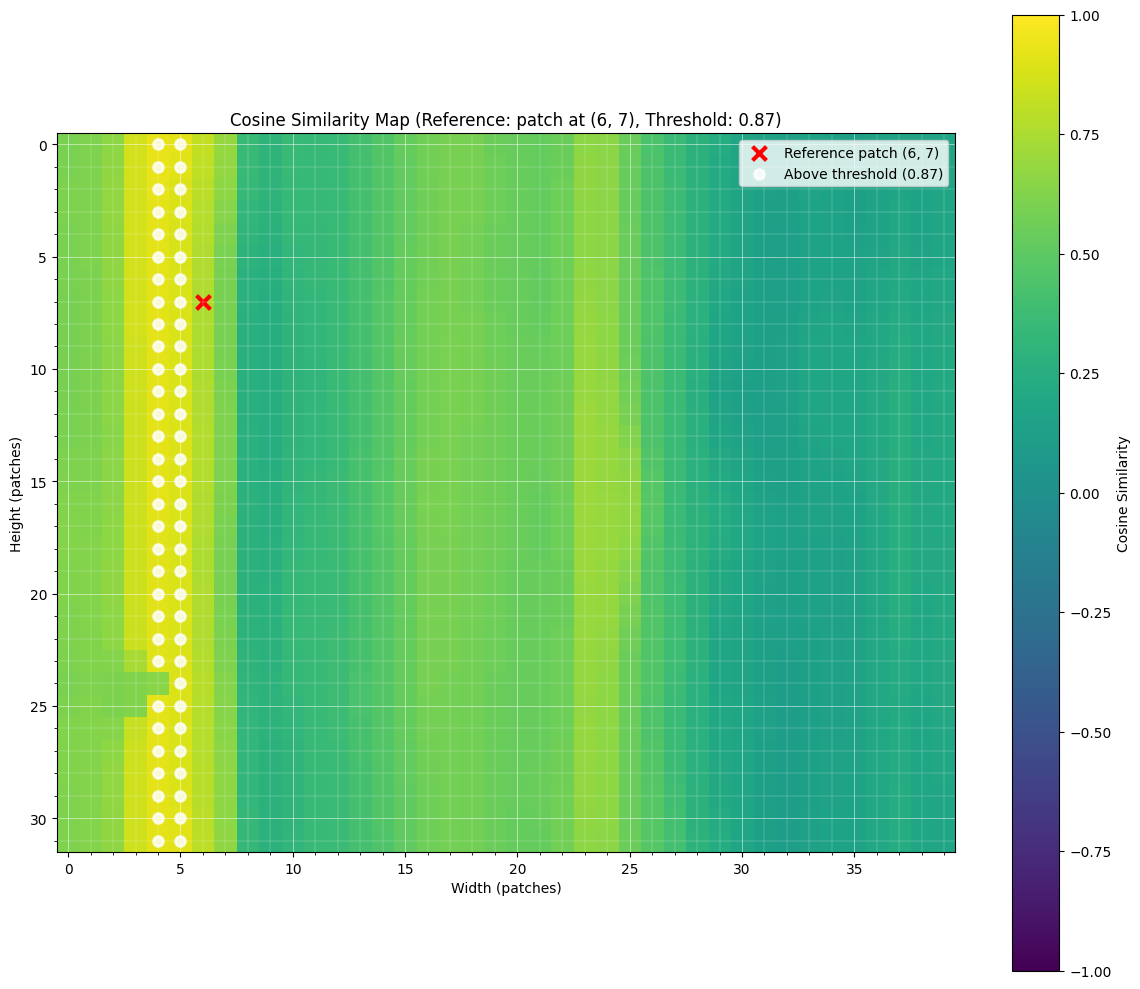

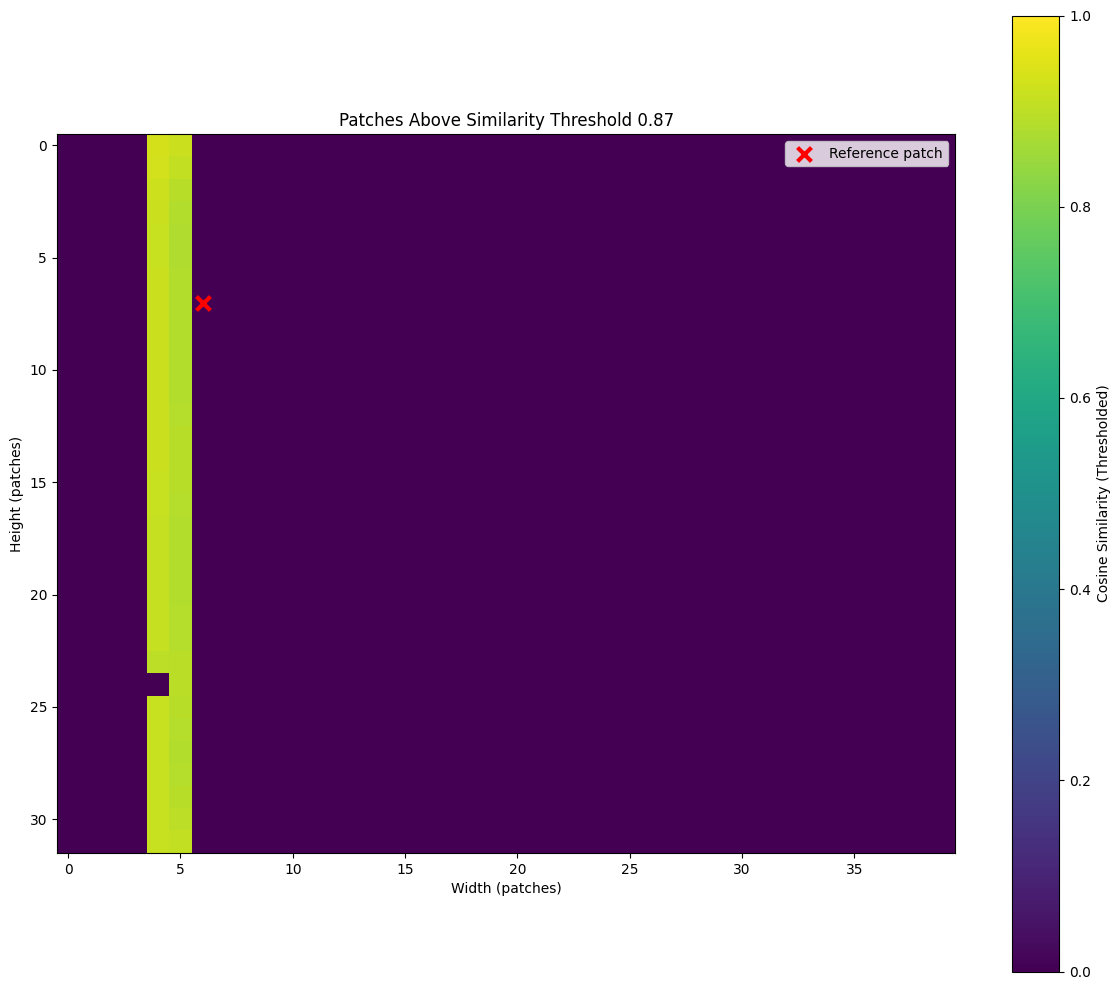

In [29]:
# Get the feature vector at the specified coordinates
auth_reference_patch = auth_patch_features_2d[y_coord, x_coord, :]  # Shape: [D]

# Reshape patch_features_2d to [H*W, D] for easier computation
H, W, D = forged_patch_features_2d.shape
patch_features_flat = forged_patch_features_2d.reshape(-1, D)  # Shape: [H*W, D]

# Calculate cosine similarity using torch.nn.functional.cosine_similarity
cosine_similarities = F.cosine_similarity(
    auth_reference_patch.unsqueeze(0),  # Shape: [1, D]
    patch_features_flat,           # Shape: [H*W, D]
    dim=1,
)

# Reshape back to 2D spatial layout
cosine_similarity_map = cosine_similarities.reshape(H, W)  # Shape: [H, W]

# Add threshold for cosine similarity
SIMILARITY_THRESHOLD = 0.87  # Adjust this value as needed

# Create a binary mask for patches above threshold
high_similarity_mask = cosine_similarity_map > SIMILARITY_THRESHOLD

print(f"Reference patch coordinates: ({x_coord}, {y_coord})")
print(f"Cosine similarity map shape: {cosine_similarity_map.shape}")
print(f"Max similarity: {cosine_similarity_map.max():.4f}")
print(f"Min similarity: {cosine_similarity_map.min():.4f}")
print(f"Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"Number of patches above threshold: {high_similarity_mask.sum()}")

# Visualize the similarity map with granular grid
plt.figure(figsize=(12, 10))
plt.imshow(cosine_similarity_map, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title(f'Cosine Similarity Map (Reference: patch at ({x_coord}, {y_coord}), Threshold: {SIMILARITY_THRESHOLD})')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')

# Add granular grid
plt.grid(True, which='major', color='white', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', color='white', linewidth=0.3, alpha=0.5)

# Set major ticks every 5 patches and minor ticks every 1 patch
plt.xticks(range(0, W, 5))
plt.yticks(range(0, H, 5))
plt.gca().set_xticks(range(0, W, 1), minor=True)
plt.gca().set_yticks(range(0, H, 1), minor=True)

# Mark the reference patch
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch ({x_coord}, {y_coord})')

# Mark patches above threshold with white circles
high_sim_coords = np.where(high_similarity_mask)
plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o', 
           facecolors='none', edgecolors='white', linewidths=2, alpha=0.8, 
           label=f'Above threshold ({SIMILARITY_THRESHOLD})')

plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show only patches above threshold
plt.figure(figsize=(12, 10))
thresholded_map = np.where(high_similarity_mask, cosine_similarity_map, 0)
plt.imshow(thresholded_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity (Thresholded)')
plt.title(f'Patches Above Similarity Threshold {SIMILARITY_THRESHOLD}')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch')
plt.legend()
plt.tight_layout()
plt.show()

#### Remove multiple masks from authentic

In [ ]:
def count_components_floodfill(name: str, index:int, mask: np.ndarray, connectivity: int = 8):
    """
    Count connected True components in a 2D boolean numpy mask using flood-fill (iterative).
    Args:
        mask: 2D boolean numpy array
        connectivity: 4 or 8 (neighbour connectivity)
    Returns:
        n_components: int
        sizes: list of int (size of each component)
        labels: 2D int32 array same shape as mask where 0 = background, 1..n = component ids
    """
    assert mask.ndim == 2, "mask must be 2D"
    assert connectivity in (4, 8)
    H, W = mask.shape
    visited = np.zeros((H, W), dtype=bool)
    labels = np.zeros((H, W), dtype=np.int32)
    neighbors4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    neighbors8 = neighbors4 + [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    neighbors = neighbors8 if connectivity == 8 else neighbors4

    comp_id = 0
    sizes = []

    for y in range(H):
        for x in range(W):
            if mask[y, x] and not visited[y, x]:
                comp_id += 1
                q = deque()
                q.append((y, x))
                visited[y, x] = True
                labels[y, x] = comp_id
                size = 0
                while q:
                    cy, cx = q.popleft()
                    size += 1
                    for dy, dx in neighbors:
                        ny, nx = cy + dy, cx + dx
                        if 0 <= ny < H and 0 <= nx < W and not visited[ny, nx] and mask[ny, nx]:
                            visited[ny, nx] = True
                            labels[ny, nx] = comp_id
                            q.append((ny, nx))
                sizes.append(size)

    return name, index, comp_id, sizes, labels

res = Parallel(n_jobs=-1)(delayed(count_components_floodfill)(row["mask_name"], row["index"], row["auth_mask"], connectivity=8) for row in tqdm(masked_entities))

100%|██████████| 3187/3187 [03:02<00:00, 17.47it/s]


In [ ]:
_ = sorted(res, key=lambda x: x[2], reverse=True)
_[0]

('19684',
 0,
 152,
 [5779,
  689,
  223,
  3,
  21,
  1,
  6,
  880,
  3985,
  2,
  117,
  1724,
  812,
  362,
  91,
  39,
  34,
  18,
  238,
  2,
  2,
  3,
  3,
  8,
  2,
  1,
  2,
  1,
  21,
  1,
  1,
  7,
  2,
  21,
  6,
  2,
  8,
  2,
  1,
  1,
  1,
  1,
  4,
  1,
  847,
  661,
  1,
  32,
  11,
  4,
  38,
  50,
  3,
  12,
  14,
  5,
  3,
  1,
  1,
  1,
  1,
  159,
  41,
  1,
  1385,
  2,
  1,
  1,
  3,
  1,
  705,
  648,
  1,
  1,
  2,
  8,
  1,
  9,
  1,
  23,
  1,
  1,
  2,
  3,
  15,
  2,
  1,
  14,
  3,
  12,
  20,
  1,
  1,
  12,
  1,
  1,
  1,
  2,
  3,
  3,
  1,
  3,
  1,
  3,
  1,
  5,
  1,
  167,
  1183,
  2,
  9,
  1,
  6,
  569,
  212,
  4,
  1,
  6,
  1,
  1,
  1,
  1,
  1,
  1,
  249750,
  12,
  3,
  1,
  1,
  3,
  5,
  1,
  37,
  1,
  12,
  789,
  1,
  1406,
  1,
  1,
  156,
  24,
  3,
  1,
  1,
  9,
  16,
  1,
  2,
  1,
  1,
  1],
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0,

In [33]:
len(masked_entities)

1

19684 0


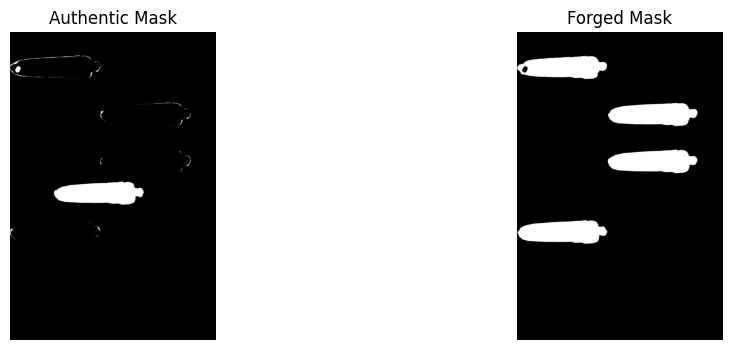

In [ ]:
# for i,row in tqdm(enumerate(masked_entities[158:159])):

if True:
    
    row = [x for x in masked_entities if x["mask_name"]=='19684' and x["index"]==0][0]
    
    print(row["mask_name"], row["index"])
    
    forged_mask = row['forged_mask']
    auth_mask = row['auth_mask']
    
    # visualize the masks
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(auth_mask, cmap='gray')
    plt.title(f'Authentic Mask')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(forged_mask, cmap='gray')
    plt.title(f'Forged Mask')
    plt.axis('off')
    
    
    
    plt.show()